# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [47]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix , adjusted_rand_score 
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [48]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [49]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('General Population data:', azdias.shape)
print('Features info data:', feat_info.shape)

General Population data: (891221, 85)
Features info data: (85, 4)


In [50]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [51]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [52]:
azdias.isnull().any().sum() # we have 53 features that have Null values in general population data 

53

In [53]:
azdias.isnull().sum().sum() # total number of NaN values in azdias dataframe 

4896838

In [54]:
# percentage of Nan values in each column of azdias dataframe 
for col in azdias.columns:
    print(col, azdias[col].isnull().sum()/azdias.shape[0])

AGER_TYP 0.0
ALTERSKATEGORIE_GROB 0.0
ANREDE_KZ 0.0
CJT_GESAMTTYP 0.00544646052999
FINANZ_MINIMALIST 0.0
FINANZ_SPARER 0.0
FINANZ_VORSORGER 0.0
FINANZ_ANLEGER 0.0
FINANZ_UNAUFFAELLIGER 0.0
FINANZ_HAUSBAUER 0.0
FINANZTYP 0.0
GEBURTSJAHR 0.0
GFK_URLAUBERTYP 0.00544646052999
GREEN_AVANTGARDE 0.0
HEALTH_TYP 0.0
LP_LEBENSPHASE_FEIN 0.00544646052999
LP_LEBENSPHASE_GROB 0.00544646052999
LP_FAMILIE_FEIN 0.00544646052999
LP_FAMILIE_GROB 0.00544646052999
LP_STATUS_FEIN 0.00544646052999
LP_STATUS_GROB 0.00544646052999
NATIONALITAET_KZ 0.0
PRAEGENDE_JUGENDJAHRE 0.0
RETOURTYP_BK_S 0.00544646052999
SEMIO_SOZ 0.0
SEMIO_FAM 0.0
SEMIO_REL 0.0
SEMIO_MAT 0.0
SEMIO_VERT 0.0
SEMIO_LUST 0.0
SEMIO_ERL 0.0
SEMIO_KULT 0.0
SEMIO_RAT 0.0
SEMIO_KRIT 0.0
SEMIO_DOM 0.0
SEMIO_KAEM 0.0
SEMIO_PFLICHT 0.0
SEMIO_TRADV 0.0
SHOPPER_TYP 0.0
SOHO_KZ 0.0824700046341
TITEL_KZ 0.0824700046341
VERS_TYP 0.0
ZABEOTYP 0.0
ALTER_HH 0.0824700046341
ANZ_PERSONEN 0.0824700046341
ANZ_TITEL 0.0824700046341
HH_EINKOMMEN_SCORE 0.020587486

In [55]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [56]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [57]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,MIN_GEBAEUDEJAHR,person,ordinal,[-1]
freq,1,43,49,26


In [58]:
feat_info['missing_or_unknown'].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[XX]         1
[-1,XX]      1
[-1,0,9]     1
[-1,X]       1
Name: missing_or_unknown, dtype: int64

In [59]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [60]:
# Identify missing or unknown data values and convert them to NaNs.

# The below code I got it from udacity knowledge section as I was looking for explaination to understand what excatly is
# required in this part 

for row in range(len(feat_info)):
    m_o_u = feat_info.iloc[row]["missing_or_unknown"]
    m_o_u = m_o_u.strip("[").strip("]").split(sep=",")
    m_o_u = [int(self) if (self!="" and self!="X" and self!="XX") else self for self in m_o_u]
# Modifying azdias as well. According to the changes we made in feature_info
    if m_o_u != [""]:
        azdias = azdias.replace({feat_info.iloc[row]["attribute"]: m_o_u}, np.nan)



In [61]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [62]:
azdias.isnull().any().sum() # to check the number after we applying the np.nan 

61

In [63]:
azdias.isnull().sum().sum() # total number of NaN values in azdias dataframe after applying np.nan

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [64]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# percentage of Nan values in each column of azdias dataframe after applying np.nan 
for col in azdias.columns:
    print(col, azdias[col].isnull().sum()/azdias.shape[0]*100)

AGER_TYP 76.9554352961
ALTERSKATEGORIE_GROB 0.323264375503
ANREDE_KZ 0.0
CJT_GESAMTTYP 0.544646052999
FINANZ_MINIMALIST 0.0
FINANZ_SPARER 0.0
FINANZ_VORSORGER 0.0
FINANZ_ANLEGER 0.0
FINANZ_UNAUFFAELLIGER 0.0
FINANZ_HAUSBAUER 0.0
FINANZTYP 0.0
GEBURTSJAHR 44.0202822869
GFK_URLAUBERTYP 0.544646052999
GREEN_AVANTGARDE 0.0
HEALTH_TYP 12.4768155149
LP_LEBENSPHASE_FEIN 10.9548585592
LP_LEBENSPHASE_GROB 10.6115093787
LP_FAMILIE_FEIN 8.72869916665
LP_FAMILIE_GROB 8.72869916665
LP_STATUS_FEIN 0.544646052999
LP_STATUS_GROB 0.544646052999
NATIONALITAET_KZ 12.1535511394
PRAEGENDE_JUGENDJAHRE 12.1366080916
RETOURTYP_BK_S 0.544646052999
SEMIO_SOZ 0.0
SEMIO_FAM 0.0
SEMIO_REL 0.0
SEMIO_MAT 0.0
SEMIO_VERT 0.0
SEMIO_LUST 0.0
SEMIO_ERL 0.0
SEMIO_KULT 0.0
SEMIO_RAT 0.0
SEMIO_KRIT 0.0
SEMIO_DOM 0.0
SEMIO_KAEM 0.0
SEMIO_PFLICHT 0.0
SEMIO_TRADV 0.0
SHOPPER_TYP 12.4768155149
SOHO_KZ 8.24700046341
TITEL_KZ 99.7576358726
VERS_TYP 12.4768155149
ZABEOTYP 0.0
ALTER_HH 34.8136994079
ANZ_PERSONEN 8.24700046341
ANZ_T

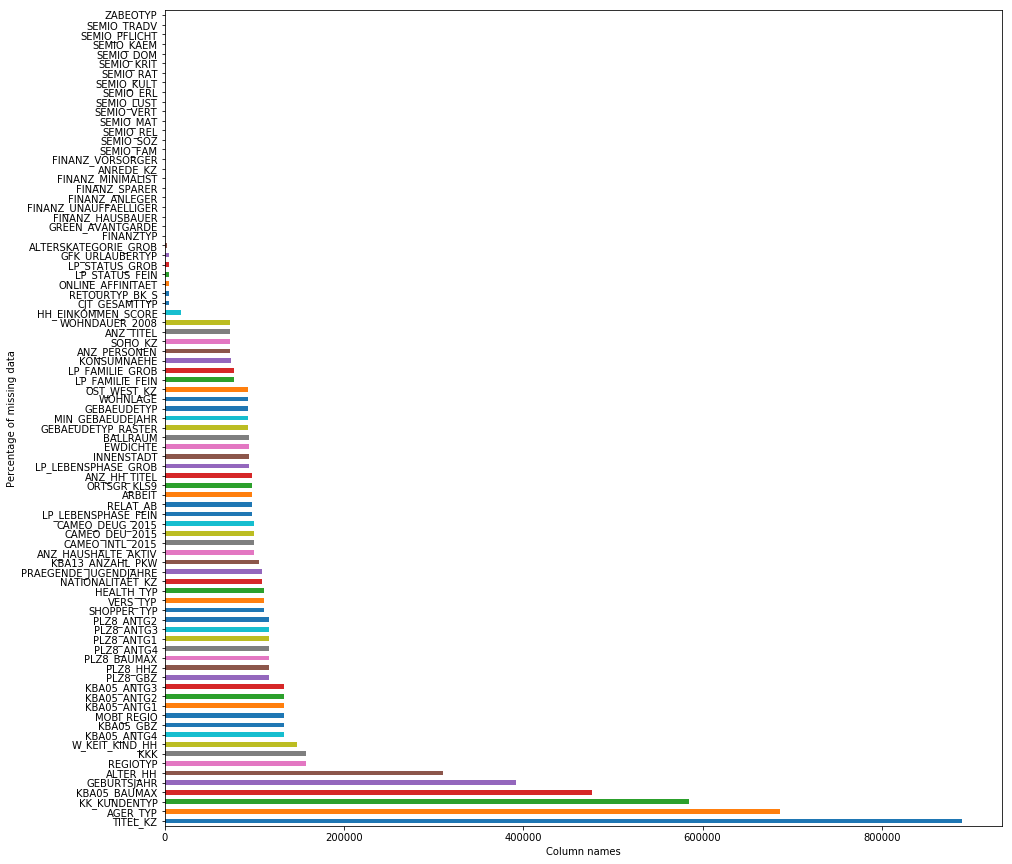

In [65]:
# Investigate patterns in the amount of missing data in each column.

# for this part of the project and after I read some questions and mentors comments on Udacity knowledge I prefered to \
# use barplot here instead of histogram as it will be more clear in showing bar names and which ones are outliers

azdias.isnull().sum().sort_values(ascending = False).plot.barh(figsize=(15,15))
plt.xlabel('Column names')
plt.ylabel('Percentage of missing data')
plt.show()

In [66]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# from the bar chart above we can clearly see there are 6 outliers here which their values exceeding 200000 which are : 
# ["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"]  

azdias = azdias.drop(["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"], axis = 1)

The coming two cells are just to check that these columns have been dropped from the original dataset

In [67]:
azdias.shape

(891221, 79)

In [68]:
dropped_col = ["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"]

for i in range(len(dropped_col)):
    if dropped_col[i] not in azdias.columns:
        print(True)
    else:
        print(False)

True
True
True
True
True
True


#### Discussion 1.1.2: Assess Missing Data in Each Column


first of all before we replaced the encoded values e.g: (-1 ,9) in the original dataset we had a smaller number than of Nan values (4896838) than the number we got after repalcement which is (8373929) and that's because every encoded value in feat_info["attribue"] was converted to NaN in azdias dataframe since attributes rows are the azdias dataframe columns. The columns that were removed are ["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"] and the common pattern between those columns is that the proportion of missing value after converting exceeded 20% comparing to other columns. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [69]:
# How much data is missing in each row of the dataset?

num_nan_row = azdias.isnull().sum(axis=1)
num_nan_row # in order to get the proportion of nan values for each row we need to divide by the total number of features (79)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [70]:
prop_nan_row = (num_nan_row / azdias.shape[1])*100
prop_nan_row

0         54.430380
1          0.000000
2          0.000000
3          8.860759
4          0.000000
5          0.000000
6          0.000000
7          0.000000
8          0.000000
9          0.000000
10         0.000000
11        59.493671
12         7.594937
13        10.126582
14        59.493671
15        10.126582
16         7.594937
17        59.493671
18         3.797468
19         0.000000
20        12.658228
21         0.000000
22         0.000000
23        10.126582
24        59.493671
25         6.329114
26        24.050633
27         0.000000
28         0.000000
29         2.531646
            ...    
891191     0.000000
891192     0.000000
891193     0.000000
891194     0.000000
891195     0.000000
891196     0.000000
891197     0.000000
891198     0.000000
891199     0.000000
891200     0.000000
891201     0.000000
891202     0.000000
891203    17.721519
891204     0.000000
891205     0.000000
891206     0.000000
891207     0.000000
891208     3.797468
891209     0.000000


In [71]:
prop_nan_row.value_counts()

0.000000     623209
59.493671     45578
2.531646      27926
54.430380     27369
10.126582     24592
6.329114      22515
3.797468      17629
1.265823      15738
7.594937      13771
8.860759      13714
5.063291      12607
43.037975     10816
12.658228      5410
18.987342      4743
44.303797      3911
16.455696      3255
11.392405      3042
41.772152      2985
20.253165      2505
17.721519      2243
24.050633      1180
13.924051      1127
15.189873       766
21.518987       677
46.835443       538
56.962025       494
22.784810       428
48.101266       421
51.898734       356
25.316456       349
40.506329       206
55.696203       155
26.582278       150
50.632911       137
29.113924       132
27.848101       129
45.569620        84
49.367089        77
30.379747        69
32.911392        59
31.645570        55
34.177215        24
53.164557        21
36.708861        12
37.974684         6
35.443038         5
39.240506         3
62.025316         2
60.759494         1
dtype: int64

In [72]:
num_nan_row.value_counts()

0     623209
47     45578
2      27926
43     27369
8      24592
5      22515
3      17629
1      15738
6      13771
7      13714
4      12607
34     10816
10      5410
15      4743
35      3911
13      3255
9       3042
33      2985
16      2505
14      2243
19      1180
11      1127
12       766
17       677
37       538
45       494
18       428
38       421
41       356
20       349
32       206
44       155
21       150
40       137
23       132
22       129
36        84
39        77
24        69
26        59
25        55
27        24
42        21
29        12
30         6
28         5
31         3
49         2
48         1
dtype: int64

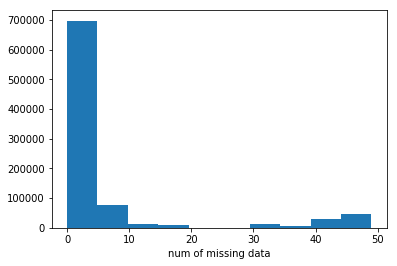

In [73]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

plt.hist(num_nan_row.sort_values(ascending = False), bins = 10); 
plt.xlabel('num of missing data'); 

**From the above histogram we can consider our threshold here is 20** 

In [74]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# let's make two subsets of data using 20 as a threshold :

df_less_nan_rows = azdias[azdias.isnull().sum(axis=1) <= 20] 
df_more_nan_rows = azdias[azdias.isnull().sum(axis=1) > 20]

In [75]:
print('less missing values df: ', df_less_nan_rows.shape)
print('more missing values df: ', df_more_nan_rows.shape)

less missing values df:  (797426, 79)
more missing values df:  (93795, 79)


In [76]:
def comparison_dist(df1, df2, column):
    fig, ax = plt.subplots(1, 2)
    fig.suptitle('comparison distribuition of columns')
    sns.countplot(df1[column], ax = ax[0])
    sns.countplot(df2[column], ax = ax[1])
    ax[0].title.set_text('less nan')
    ax[1].title.set_text('more nan')
    plt.subplots_adjust(wspace = 0.5)
    fig.show()
    return

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


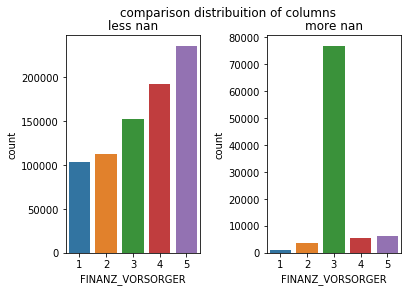

In [77]:
comparison_dist(df_less_nan_rows, df_more_nan_rows, "FINANZ_VORSORGER");

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


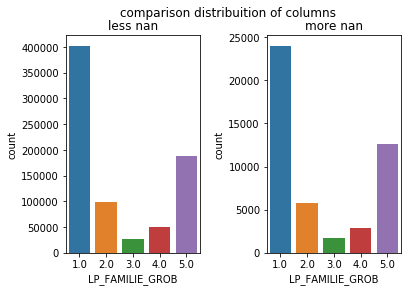

In [78]:
comparison_dist(df_less_nan_rows, df_more_nan_rows, "LP_FAMILIE_GROB");

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


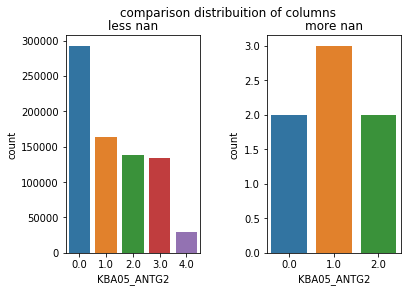

In [79]:
comparison_dist(df_less_nan_rows, df_more_nan_rows, "KBA05_ANTG2");

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


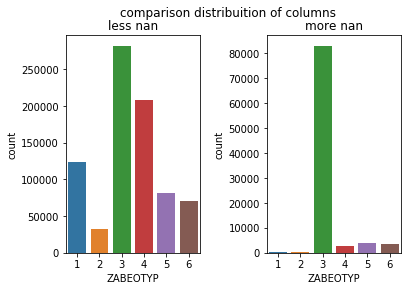

In [80]:
comparison_dist(df_less_nan_rows, df_more_nan_rows, "ZABEOTYP");

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


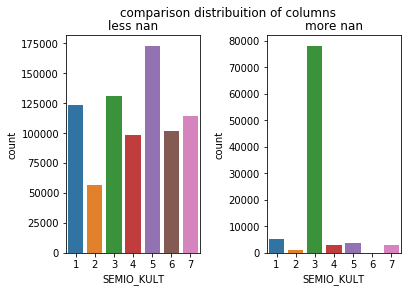

In [81]:
 comparison_dist(df_less_nan_rows, df_more_nan_rows, "SEMIO_KULT");

#### Discussion 1.1.3: Assess Missing Data in Each Row

Here We divided our original datasets into two subsets taking 20% of row missing values as a threshold for sepparation , and out of 5 randomly chosen columns we can clearly see that 4 of them have a completely different distribution between dataframe with less missing values **df_less_nan_rows** and dataframe with many missing values **df_more_nan_rows**. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [82]:
feat_info.head(2)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [83]:
# How many features are there of each data type?

feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [84]:
for attribute in feat_info[feat_info['type'] == 'categorical']['attribute']:
    print(attribute)

AGER_TYP
ANREDE_KZ
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
KK_KUNDENTYP
GEBAEUDETYP
OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [85]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything

for attribute in feat_info[feat_info['type'] == 'categorical']['attribute']:
    # to avoid looping in dropped columns which have been dropped earlier
    if attribute in azdias.columns:
        if azdias[attribute].nunique() == 2:
            print(attribute, azdias[attribute].unique())
# we can see here these are binary(two level)which will be kept,except OST_WEST_KZ which has to be encoded using dummy_variables

ANREDE_KZ [1 2]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ nan   1.   0.]
VERS_TYP [ nan   2.   1.]
OST_WEST_KZ [nan 'W' 'O']


In [86]:
# Re-encode categorical variable(s) to be kept in the analysis.
# since we have been adviced that to continue working with dataset that have no or few missing row values (df_less_nan_rows) \ 
# will be used here 

# There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or \ 
#create a dummy variable.

df_less_nan_rows = pd.get_dummies(df_less_nan_rows, columns = ['OST_WEST_KZ'])

In [87]:
print(df_less_nan_rows.columns[-1])
print(df_less_nan_rows.columns[-2])

OST_WEST_KZ_W
OST_WEST_KZ_O


In [88]:
# for more than 3 values of multi-categorical values , we will go with dropping them 

for attribute in feat_info[feat_info['type'] == 'categorical']['attribute']:
    # to avoid looping in dropped columns which have been dropped earlier
    if attribute in azdias.columns:
        if azdias[attribute].nunique() >= 3:
            print(attribute, azdias[attribute].unique())

CJT_GESAMTTYP [  2.   5.   3.   4.   1.   6.  nan]
FINANZTYP [4 1 6 5 2 3]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
LP_FAMILIE_FEIN [  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
LP_FAMILIE_GROB [  2.   3.   1.  nan   5.   4.]
LP_STATUS_FEIN [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ [ nan   1.   3.   2.]
SHOPPER_TYP [ nan   3.   2.   1.   0.]
ZABEOTYP [3 5 4 1 6 2]
GEBAEUDETYP [ nan   8.   1.   3.   2.   6.   4.   5.]
CAMEO_DEUG_2015 [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [89]:
df_less_nan_rows = df_less_nan_rows.drop(['CJT_GESAMTTYP','FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
                                         'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                                         'SHOPPER_TYP','ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
                                         'OST_WEST_KZ_O'] , axis = 1) 
# Here i'll drop one (OST_WEST_KZ_O) which resulted from dummy variables as per dummy variables rule.   

In [90]:
df_less_nan_rows.shape

(797426, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

if we looked at the value_counts() cell above we will see that we have 21 categrical values , 3 if them were already dropped earlier whcih are ('AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP') ,  then we have 5 binary values ('ANREDE_KZ','GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ') which we kept them with doing anything except for 'OST_WEST_KZ' which has been encoded using dummuy variables as it was binary with non-numeric values, and for the remaining 13 categorical values I decided to drop them since they have more multi-level values.  

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [91]:
for attribute in feat_info[feat_info['type'] == 'mixed']['attribute']:
    print(attribute)

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
KBA05_BAUMAX
PLZ8_BAUMAX


**if we looked at Data_Dictionary we will see that each float number represents a combination of info related a different dimension , for instance regardless of whether a nation is east or west you would see that the movement and decade are attached to certain values :  mainstream values are (1,3,5,8,10,12,14) and avantgarde values are (2,4,6,7,9,11,13,15). And the same applies for decade but with a different distribution like (1,2 represent 40s) , (3,4 represent 50s) and so on.** 

In [92]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

df_less_nan_rows['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182903
8.0     141542
10.0     85767
5.0      84665
3.0      53822
15.0     42521
11.0     35735
9.0      33563
6.0      25651
12.0     24440
1.0      20662
4.0      20450
2.0       7479
13.0      5759
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [93]:
# to check for nan as it will be counted in value_counts() above 
df_less_nan_rows['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [94]:
# two dictionaries will be created one for movement and one for decade : 
# by the way as the movement is binary values (0: mainstream) and (1: avantgarde) 
movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1, np.nan : np.nan}
decade = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80 , 14:90, 15:90, np.nan : np.nan}

In [95]:
# creating two new columns of df_less_nan_rows['PRAEGENDE_JUGENDJAHRE'] then apply the above two dictionaries on them 

df_less_nan_rows['MOVEMENT'] = df_less_nan_rows['PRAEGENDE_JUGENDJAHRE']
df_less_nan_rows['DECADE'] = df_less_nan_rows['PRAEGENDE_JUGENDJAHRE']

In [96]:
df_less_nan_rows['MOVEMENT'] = df_less_nan_rows['MOVEMENT'].replace(movement)
df_less_nan_rows['DECADE'] = df_less_nan_rows['DECADE'].replace(decade)

In [97]:
df_less_nan_rows.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,MOVEMENT,DECADE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0.0,90.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1,1.0,90.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,0.0,70.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0.0,70.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0.0,50.0


In [98]:
df_less_nan_rows[['PRAEGENDE_JUGENDJAHRE','MOVEMENT','DECADE']].head()

,PRAEGENDE_JUGENDJAHRE,MOVEMENT,DECADE
1,14.0,0.0,90.0
2,15.0,1.0,90.0
3,8.0,0.0,70.0
4,8.0,0.0,70.0
5,3.0,0.0,50.0


In [99]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

df_less_nan_rows['CAMEO_INTL_2015'].value_counts()


51    133673
41     92309
24     91099
14     62851
43     56653
54     45376
25     39605
22     33137
23     26667
13     26311
45     26126
55     23939
52     20538
31     18979
34     18517
15     16966
44     14817
12     13234
35     10352
32     10346
33      9928
Name: CAMEO_INTL_2015, dtype: int64

In [100]:
df_less_nan_rows['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

**if we took a look at column 'CAMEO_INTL_2015' in data dictionary we will see that the wealth is divided into 5 different categories (Wealthy Households, Prosperous Households, Comfortable Households, Less Affluent Households and Poorer Households) these will be given the values from 1 to 5 respectively. And for life stage we can clearly see that it also has 5 different categories (Pre-Family Couples & Singles, Young Couples With Children, Families With School Age Children, Older Families &  Mature Couples and Elders In Retirement) so these values will also be given values of 1 to 5 respectively.**

In [101]:
# an important note here is that before we create new dicionaries and map them to WEALTH and LIFE_STAGE columns we firstly \
# need to convert data type of 'CAMEO_INTL_2015' to float/int instead of being object so to do that : 

df_less_nan_rows['CAMEO_INTL_2015'] = pd.to_numeric(df_less_nan_rows['CAMEO_INTL_2015'])

In [102]:
df_less_nan_rows['CAMEO_INTL_2015'].unique()

array([ 51.,  24.,  12.,  43.,  54.,  22.,  14.,  13.,  15.,  33.,  41.,
        34.,  55.,  nan,  25.,  23.,  31.,  52.,  35.,  45.,  44.,  32.])

In [103]:
wealth = {11:1, 12:1, 13:1, 14:1, 15:1, 
          21:2, 22:2, 23:2, 24:2, 25:2 , 
          31:3, 32:3, 33:3, 34:3, 35:3, 
          41:4, 42:4, 43:4, 44:4, 45:4, 
          51:5, 52:5, 53:5, 54:5, 55:5, np.nan:np.nan}

life_stage = {11:1, 21:1, 31:1, 41:1, 51:1, 
              12:2, 22:2, 32:2, 42:2, 52:2, 
              13:3, 23:3, 33:3, 43:3, 53:3, 
              14:4, 24:4, 34:4, 44:4, 54:4, 
              15:5, 25:5, 35:5, 45:5, 55:5, np.nan:np.nan}

df_less_nan_rows['WEALTH'] = df_less_nan_rows['CAMEO_INTL_2015']
df_less_nan_rows['LIFE_STAGE'] = df_less_nan_rows['CAMEO_INTL_2015']

df_less_nan_rows['WEALTH'] = df_less_nan_rows['WEALTH'].replace(wealth)
df_less_nan_rows['LIFE_STAGE'] = df_less_nan_rows['LIFE_STAGE'].replace(life_stage)

In [104]:
df_less_nan_rows[['CAMEO_INTL_2015','WEALTH','LIFE_STAGE']].head()

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51.0,5.0,1.0
2,24.0,2.0,4.0
3,12.0,1.0,2.0
4,43.0,4.0,3.0
5,54.0,5.0,4.0


In [105]:
df_less_nan_rows = df_less_nan_rows.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1)
df_less_nan_rows.shape

(797426, 68)

#### Discussion 1.2.2: Engineer Mixed-Type Features

for 'PRAEGENDE_JUGENDJAHRE' column we have engineered two values out of it's float values into MOVEMENT and DECADE depending on the data from Data_Dictionary file after that we dropped the 'PRAEGENDE_JUGENDJAHRE' column itself. And for 'CAMEO_INTL_2015' we first changed it's data type to be float in order to map it later then we obtained two additional columns WEALTH and LIFE_STAGE depending on Data_Dictionary file as well then we dropped the 'CAMEO_INTL_2015' itself. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [106]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# here we will drop all the column that we still that having mixed values as we just want to keep the columns with numeric, \
# interval, ordinal type and binary features. 

for attribute in feat_info[feat_info['type'] == 'mixed']['attribute']:
    if attribute in df_less_nan_rows.columns:
        df_less_nan_rows.drop(attribute, axis = 1, inplace = True)
        

In [107]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

print(df_less_nan_rows.shape)
print(df_less_nan_rows.columns)

(797426, 64)
Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
     

In [108]:
df_col_lst = list(df_less_nan_rows.columns)
mix_col = [] 

for attribute in feat_info[feat_info['type'] == 'mixed']['attribute']:
    mix_col.append(attribute)
    

In [109]:
for name in mix_col:
    if name in df_col_lst:
        print(name)
    else:
        print('col is dropped')

col is dropped
col is dropped
col is dropped
col is dropped
col is dropped
col is dropped
col is dropped


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [110]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    for row in range(len(feat_info)):
        m_o_u = feat_info.iloc[row]["missing_or_unknown"]
        m_o_u = m_o_u.strip("[").strip("]").split(sep=",")
        m_o_u = [int(self) if (self!="" and self!="X" and self!="XX") else self for self in m_o_u]
        # Modifying azdias as well. According to the changes we made in feature_info
        if m_o_u != [""]:
            df = df.replace({feat_info.iloc[row]["attribute"]: m_o_u}, np.nan)
    
    # remove selected columns and rows, ...
    df = df.drop(["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"], axis = 1)
    df = df[df.isnull().sum(axis=1) <= 20]
    
    # select, re-encode, and engineer column values.
    df = pd.get_dummies(df, columns = ['OST_WEST_KZ'])
    df = df.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                  'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 
                  'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'OST_WEST_KZ_O'] , axis = 1) 
    movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1, np.nan : np.nan}
    decade = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80 , 14:90, 15:90, np.nan : np.nan}
    
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'] = df['MOVEMENT'].replace(movement)
    df['DECADE'] = df['DECADE'].replace(decade)
    
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    
    wealth = {11:1, 12:1, 13:1, 14:1, 15:1, 
          21:2, 22:2, 23:2, 24:2, 25:2 , 
          31:3, 32:3, 33:3, 34:3, 35:3, 
          41:4, 42:4, 43:4, 44:4, 45:4, 
          51:5, 52:5, 53:5, 54:5, 55:5, np.nan:np.nan}

    life_stage = {11:1, 21:1, 31:1, 41:1, 51:1, 
              12:2, 22:2, 32:2, 42:2, 52:2, 
              13:3, 23:3, 33:3, 43:3, 53:3, 
              14:4, 24:4, 34:4, 44:4, 54:4, 
              15:5, 25:5, 35:5, 45:5, 55:5, np.nan:np.nan}

    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']

    df['WEALTH'] = df['WEALTH'].replace(wealth)
    df['LIFE_STAGE'] = df['LIFE_STAGE'].replace(life_stage)
    
    df = df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1)
    
    for attribute in feat_info[feat_info['type'] == 'mixed']['attribute']:
        if attribute in df.columns:
            df.drop(attribute, axis = 1, inplace = True)
    
    # Return the cleaned dataframe.
    return df        

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [111]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print('number of total NaN values:', df_less_nan_rows.isnull().sum().sum())
print('number of features contain NaN Values:', df_less_nan_rows.isnull().any().sum())

number of total NaN values: 751879
number of features contain NaN Values: 35


In [112]:
imputer  = Imputer(missing_values = np.nan, strategy = 'median')
# to keep it as a DataFrame instead of np.ndarray which is resulted from imputer fit_transform 
azdias_imputed_df_1 = pd.DataFrame(imputer.fit_transform(df_less_nan_rows), columns = df_less_nan_rows.columns)

In [113]:
print(azdias_imputed_df_1.isnull().sum().sum())
print(azdias_imputed_df_1.isnull().any().sum())
print(azdias_imputed_df_1.shape)

0
0
(797426, 64)


In [114]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled_df = pd.DataFrame(scaler.fit_transform(azdias_imputed_df_1), columns = azdias_imputed_df_1.columns)

In [115]:
azdias_scaled_df.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,...,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05
mean,8.509483e-17,8.277811e-17,1.346548e-16,-8.425725e-17,-3.776250e-17,-9.630418e-17,1.835286e-16,-8.126334e-17,-1.561111e-17,-1.607446e-17,...,-1.149270e-16,2.929757e-17,-1.233207e-16,-1.578420e-16,1.531484e-16,1.304490e-16,-1.561111e-17,-1.740924e-16,3.111530e-17,-1.085293e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766334e+00,-1.043765e+00,-1.494609e+00,-1.155304e+00,-1.766955e+00,-1.249881e+00,-1.184467e+00,-1.502317e+00,-5.305674e-01,-1.610682e+00,...,-2.727082e+00,-2.159703e+00,-2.173664e+00,-1.868232e+00,-1.526103e+00,-1.932411e+00,-5.305674e-01,-2.317692e+00,-1.553033e+00,-1.266758e+00
25%,-7.828722e-01,-1.043765e+00,-7.686897e-01,-1.155304e+00,-1.040726e+00,-1.249881e+00,-1.184467e+00,-7.920337e-01,-5.305674e-01,-2.572634e-01,...,-6.483994e-01,-3.373370e-01,-1.665970e-01,-5.624168e-01,-7.891542e-01,5.174882e-01,-5.305674e-01,-9.215344e-01,-8.682810e-01,-1.266758e+00
50%,2.005893e-01,9.580705e-01,-4.276997e-02,1.914482e-01,4.117312e-01,1.082835e-01,-4.697522e-01,-8.175029e-02,-5.305674e-01,-2.572634e-01,...,3.909420e-01,-3.373370e-01,-1.665970e-01,-1.271450e-01,-5.220488e-02,5.174882e-01,-5.305674e-01,-2.234558e-01,5.012232e-01,8.523069e-02
75%,1.184051e+00,9.580705e-01,6.831497e-01,8.648242e-01,1.137960e+00,7.873659e-01,9.596769e-01,6.285331e-01,-5.305674e-01,1.096155e+00,...,3.909420e-01,5.738462e-01,8.369365e-01,7.433986e-01,6.847444e-01,5.174882e-01,-5.305674e-01,1.172701e+00,1.185975e+00,7.612252e-01
max,1.184051e+00,9.580705e-01,1.409069e+00,1.538200e+00,1.137960e+00,1.466448e+00,1.674391e+00,1.338816e+00,1.884775e+00,1.096155e+00,...,1.430284e+00,1.485029e+00,1.840470e+00,1.613942e+00,1.421694e+00,5.174882e-01,1.884775e+00,1.172701e+00,1.185975e+00,1.437220e+00


In [116]:
azdias_scaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,-1.766334,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.096155,...,1.430284,0.573846,-0.166597,-0.127145,0.684744,0.517488,-0.530567,1.172701,1.185975,-1.266758
1,0.200589,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.096155,...,0.390942,0.573846,-0.166597,-0.127145,-0.789154,0.517488,1.884775,1.172701,-0.868281,0.761225
2,1.184051,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.257263,...,-0.648399,0.573846,-1.170130,-0.997689,-0.052205,0.517488,-0.530567,-0.223456,-1.553033,-0.590764
3,0.200589,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.096155,...,-0.648399,-0.337337,0.836936,0.308127,1.421694,0.517488,-0.530567,-0.223456,0.501223,0.085231
4,-1.766334,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.096155,...,1.430284,1.485029,-1.170130,-0.997689,-0.052205,0.517488,-0.530567,-1.619613,1.185975,0.761225


In [287]:
azdias_scaled = scaler.fit_transform(azdias_imputed_df_1)

(797426, 64)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [117]:
# Apply PCA to the data.
pca = PCA()
df_pca = pca.fit_transform(azdias_scaled_df)

In [118]:
# Investigate the variance accounted for by each principal component.
# the below code I took from the classroom screencast_Example_Code
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

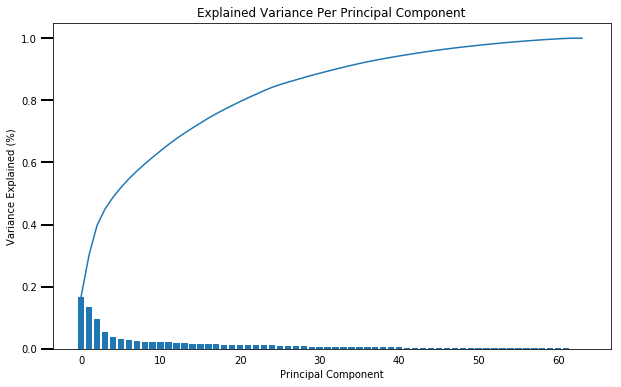

In [119]:
scree_plot(pca)

In [120]:
# from this cell we can see that starting from 33 features and more we can achieve >= 90 percent of explained variance sothe 
# n_components is 33 features which you can cleary see that from the graph abvoe 
for i in range(len(pca.explained_variance_ratio_)):
    if pca.explained_variance_ratio_[:i].sum() >= .90:
        print(i) 

33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [121]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_33 = PCA(n_components = 33)
azdias_pca_33 = pca_33.fit_transform(azdias_scaled_df)

In [122]:
print(len(pca_33.explained_variance_ratio_))
print(pca_33.explained_variance_ratio_.sum())

33
0.900032077341


### Discussion 2.2: Perform Dimensionality Reduction

Based on the screeplot above and explained_variance_ratio_ we are going to keep 33 components out of the 64 because these first 33 components will return a value of 90% as the amount of variability.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [123]:
type(pca_33.components_)

numpy.ndarray

In [124]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_pca(data, pca, n_compo):
    
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n_compo-1]
    components.sort_values(ascending=False, inplace=True)
    components = pd.concat([components.head(5), components.tail(5)])
    
    components.plot(kind='bar', title='Component ' + str(n_compo))
    plt.show()

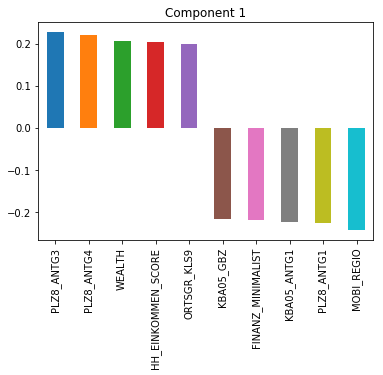

In [125]:
plot_pca(df_less_nan_rows, pca_33, 1)

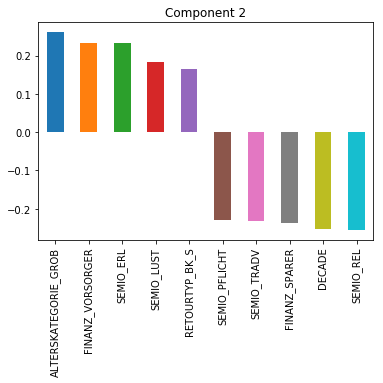

In [126]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca(df_less_nan_rows, pca_33, 2)

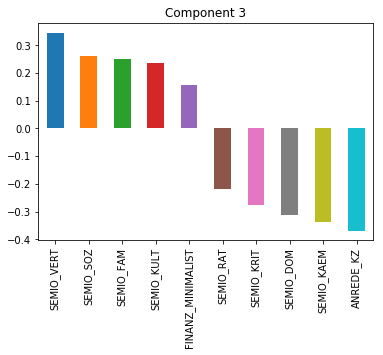

In [127]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca(df_less_nan_rows, pca_33, 3)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [128]:
# Over a number of different cluster counts...

    # run k-means clustering on the data and...
        
    # compute the average within-cluster distances.
    
def get_kmeans_score(data, center):

    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    return score


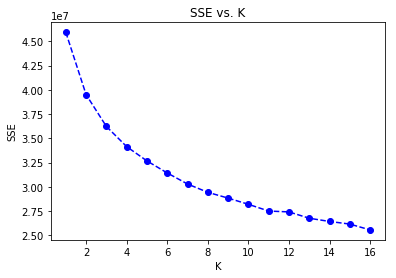

In [88]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
centers = list(range(1,17))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca_33, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [129]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_11 = KMeans(n_clusters = 11)
ger_pop_model = kmeans_11.fit(azdias_pca_33)
ger_pop_cluster = ger_pop_model.predict(azdias_pca_33)

In [130]:
ger_pop_cluster

array([8, 2, 2, ..., 7, 3, 9], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [131]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [132]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [133]:
customers.shape

(191652, 85)

In [134]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers)

In [135]:
customers.shape

(141640, 64)

In [136]:
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,5.0,5.0,1.0,2.0,1.0,1,1.0,50.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,3.0,2.0,3.0,5.0,3.0,1,1.0,50.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,3.0,4.0,1.0,3.0,1.0,1,0.0,40.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,3.0,3.0,3.0,5.0,1.0,1,0.0,70.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,5.0,5.0,3.0,7.0,5.0,1,1.0,50.0,3.0,4.0


In [137]:
customers_imputed = imputer.transform(customers)
customers_scaled = scaler.transform(customers_imputed)

In [141]:
customers_pca = pca_33.transform(customers_scaled)

In [146]:
customers_cluster_pred = ger_pop_model.predict(customers_pca)

In [147]:
customers_cluster_pred

array([6, 0, 5, ..., 6, 0, 5], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

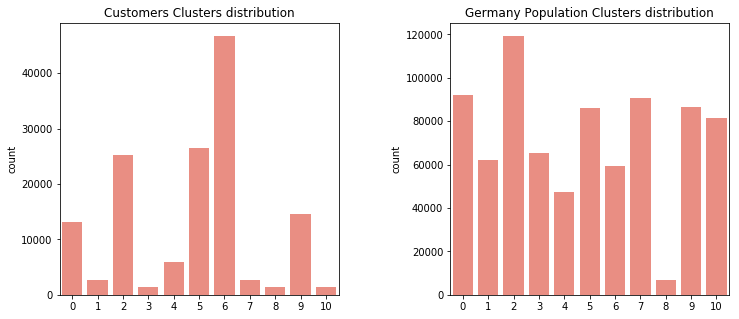

In [189]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, ax = plt.subplots(1, 2, figsize = (12,5))
sns.countplot(customers_cluster_pred, ax= ax[0], color= "salmon");
ax[0].set_title('Customers Clusters distribution');
fig.subplots_adjust(wspace=0.4)
ax[1] = sns.countplot(ger_pop_cluster, color= "salmon");
ax[1].set_title('Germany Population Clusters distribution');

In [275]:
customers_df = pd.DataFrame(customers_cluster_pred, columns=['Cluster']).reset_index().groupby('Cluster').count()
customers_df['index'] = customers_df['index']/ customers_cluster_pred.shape[0]
customers_df['index'] = customers_df['index']*100 
customers_df.rename({'index' : 'customer_prop'}, axis = 1, inplace = True)
customers_df

,customer_prop
Cluster,
0,9.309517
1,1.894945
2,17.867834
3,0.962299
4,4.149958
5,18.699520
6,32.981502
7,1.893533
8,0.982067


In [276]:
Germany_pop_df = pd.DataFrame(ger_pop_cluster, columns=['Cluster']).reset_index().groupby('Cluster').count()
Germany_pop_df['index'] = Germany_pop_df['index']/ ger_pop_cluster.shape[0]
Germany_pop_df['index'] = Germany_pop_df['index']*100 
Germany_pop_df.rename({'index' : 'Pop_prop'}, axis = 1, inplace = True)
Germany_pop_df

,Pop_prop
Cluster,
0,11.569349
1,7.791569
2,14.960134
3,8.186465
4,5.943874
5,10.788086
6,7.448967
7,11.387264
8,0.841332


In [277]:
prop_df = customers_df.join(Germany_pop_df)
prop_df

,customer_prop,Pop_prop
Cluster,,
0,9.309517,11.569349
1,1.894945,7.791569
2,17.867834,14.960134
3,0.962299,8.186465
4,4.149958,5.943874
5,18.699520,10.788086
6,32.981502,7.448967
7,1.893533,11.387264
8,0.982067,0.841332


In [323]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# we can clearly see that from the table above the 7th cluster which indexed as 6 is over-represented in the customer data \
# than in population data , we will use the plot_pca function in step 2.3 to look at the attributes of people in this cluster 
 

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.